# Lab 6: Denoising
Gizem Tabak (tabak2)

In [6]:
%matplotlib inline
import scipy.signal as sgn
import scipy.io.wavfile as wv
import matplotlib.pyplot as plt
import numpy as np
import IPython
from matplotlib import mlab as mlab
from os.path import join

plt.rcParams["figure.figsize"] = (12, 6)

## Part 1: Cleaning up the sounds
_Let’s start by cleaning up these sounds as best as we can. We will do a straightforward magnitude spectral subtraction. For all of these sounds there is only noise in the first few seconds of the record- ing so that you can learn a noise profile from there. Do the following:_

1. _Perform an STFT of the recordings_
2. _Estimate the magnitude spectrum of the noise from the beginning of the recording_

    • _It’s up to you to figure out how many seconds to use (hint: look at the spectrogram)_
3. _Perform spectral subtraction by subtracting that spectrum from the input’s magnitude STFT_

    • _Remember to clip any resulting negative values to zero_
    
    • _Try to find how much of the noise to subtract so that the output looks good_
4. _Use the original signal’s phase to convert back to a time series._

In [2]:
fs_aircomm, s_aircomm = wv.read('data/aircomm.wav')
fs_room, s_room = wv.read('data/room-speech.wav')
fs_wind, s_wind = wv.read('data/wind-speech.wav')
s_aircomm = s_aircomm/max(abs(s_aircomm))
s_room = s_room/max(abs(s_room))
s_wind = s_wind/max(abs(s_wind))
print('Aircomm')
IPython.display.display(IPython.display.Audio(s_aircomm, rate=fs_aircomm))
print('Room speech')
IPython.display.display(IPython.display.Audio(s_room, rate=fs_room))
print('Wind speech')
IPython.display.display(IPython.display.Audio(s_wind, rate=fs_wind))

Aircomm


/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Room speech


Wind speech


In [3]:
def stft( input_sound, fs, dft_size, hop_size, zero_pad, window):
    if len(np.shape(input_sound)) == 1:
        # Forward transform
        input_sound_padded = np.zeros(len(input_sound) + dft_size - zero_pad + hop_size - len(input_sound)%hop_size)
        input_sound_padded[:len(input_sound)] = input_sound
        L = len(input_sound_padded) -  dft_size
        stft_output = np.zeros([int((dft_size)/2) + 1, int(L/hop_size)], dtype=complex)
        for i in range(0, int(L/hop_size)):
            seg = input_sound_padded[(i*hop_size):(i*hop_size + dft_size - zero_pad)]
            # Choose and apply window if selected
            if window == 'triangular':
                seg = np.multiply(seg, np.bartlett(dft_size - zero_pad))
            elif window == 'hann':
                seg = np.multiply(seg, np.hanning(dft_size - zero_pad))
            elif window == 'hamming':
                seg = np.multiply(seg, np.hamming(dft_size - zero_pad))
            elif window == 'kaiser':
                seg = np.multiply(seg, np.kaiser(dft_size - zero_pad, beta=0.8))
            # Change size variable so that it will pad zeros to input    
            s_stft = np.fft.rfft(seg, dft_size)            
            stft_output[:,i] = s_stft
            
        X = np.arange(0, (int(L/hop_size)*hop_size)/fs, hop_size/fs)
        Y = np.arange(0, fs/2, fs/(2*(int((dft_size)/2) + 1)))
        # Make zero elements equal to the smallest value to avoid log(0) for plotting
        min_nonzero = np.min(stft_output[np.nonzero(stft_output)])
        stft_output[stft_output == 0] = min_nonzero

        plt.pcolormesh(X, Y, (np.abs(stft_output)**0.5), cmap='gist_gray_r')
        plt.xlabel('Time (sec)')
        plt.ylabel('Freq (Hz)')
        plt.title('DFT=%d HOP=%d PAD=%d WINDOW=%s' %(dft_size, hop_size, zero_pad, window))
        plt.grid(alpha=0.5)
        plt.colorbar()
        plt.show()

        return stft_output, X, Y
    elif len(np.shape(input_sound)) == 2:
        # Inverse transform
        L = (np.shape(input_sound)[1]+1)*hop_size
        stft_output = np.zeros([int(L)+hop_size,])
        for i in range(0, int((L - dft_size)/hop_size)):
            s_stft = np.fft.irfft(input_sound[:,i], dft_size)
            if len(window) > 0:
                # Window should only cover nonzero part, not zero paddings
                if window == 'triangular':
                    w = np.bartlett(dft_size - zero_pad)
                elif window == 'hann':
                    w = np.hanning(dft_size - zero_pad)
                elif window == 'hamming':
                    w = np.hamming(dft_size - zero_pad)
                elif window == 'kaiser':
                    w = np.kaiser(dft_size - zero_pad, beta=0.8)
                # Pad window with zeros to make dimensions equal
                window_padded = np.concatenate([w, np.zeros([zero_pad,])])
                s_stft = np.multiply(s_stft, window_padded)
            # Overlap and add
            stft_output[i*hop_size:(i*hop_size + dft_size)] += s_stft
        
        return stft_output

By looking at the spectrograms, it seems that the first 0.4 seconds of the first clip; 0-2, 5-7 and 10.2-end of the second clip and 0-2, 4.5-6.5 and 9.5-end of the third clip are speech-free, so they only contain the background noise information.

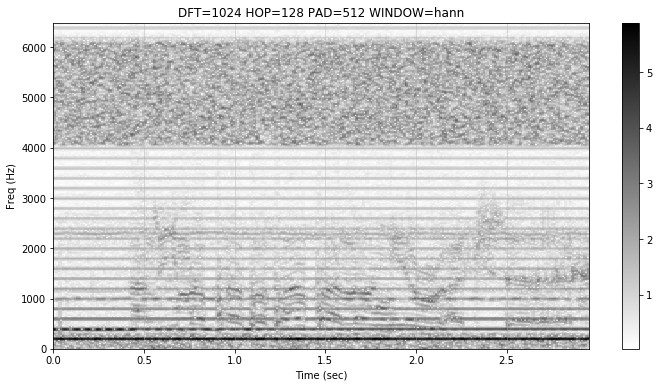

In [7]:
dft_size = 1024
hop_size = 128
zero_pad = int(dft_size/2)
window = 'hann'
stft_aircomm, t_aircomm, f_aircomm = stft(s_aircomm, fs_aircomm, dft_size, hop_size, zero_pad, window)

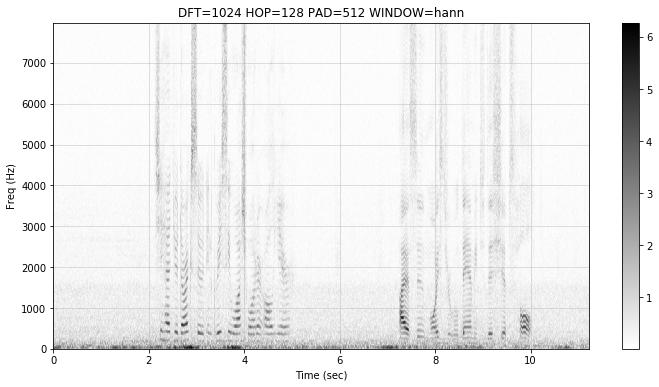

In [8]:
stft_room, t_room, f_room = stft(s_room, fs_room, dft_size, hop_size, zero_pad, window)

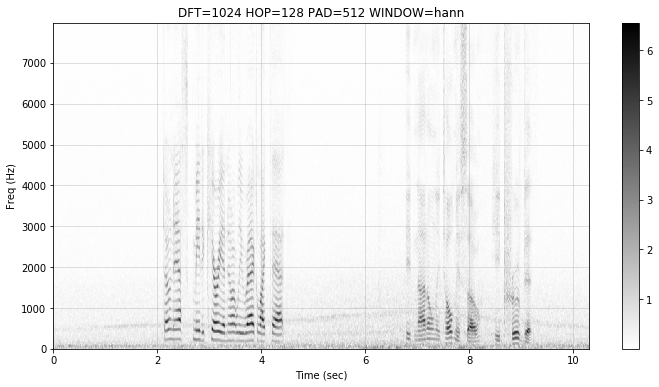

In [9]:
stft_wind, t_wind, f_wind = stft(s_wind, fs_wind, dft_size, hop_size, zero_pad, window)

Assuming the noise is stationary throughout the clips, we can estimate its spectral content by looking at the beginning of the recordings that do not contain any speech. Since we assume stationary noise, instead of taking the FFT again on that segment, I computed the average of the non-speech segments in the already computed STFT in order to estimate the noise spectrum.

For the last clip, the frequency content of the noise (wind) changes over time, which means the stationary assumption will be violated. As an attempt to compensate a little bit for that, in order to obtain a (slightly) better accurate estimate, I used the non-speech region between 1-2 secondsto estimate noise spectrum instead of 0-2 seconds. However, as it will become evident, this attempt will not be very successful to eliminate the noise completely.

The plots below show the mean spectrum of the clip averaged over time and the noise spectrum of the non-speech region at the beginning. If the stationary assumption holds, we expect better removal of noise in areas where these two plots are close, since it means that there is only noise in those areas throughout the clip. The more these plots differ from each other, the more speech content will be present in those frequencies.

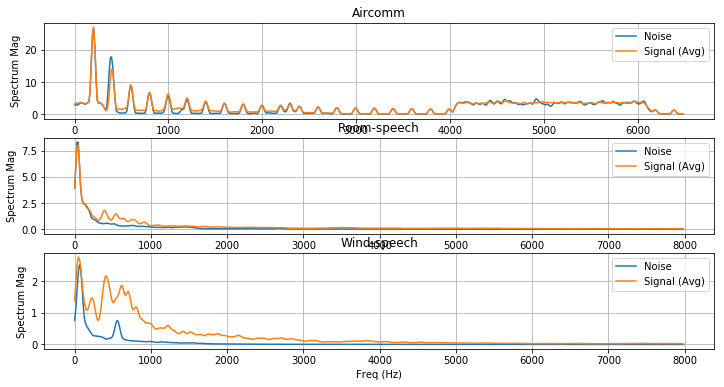

In [10]:
# n_aircomm_stft = np.fft.rfft(n_aircomm, dft_size)
n_aircomm_stft = np.mean(np.abs(stft_aircomm[:,0:int((0.4*fs_aircomm)/hop_size-1)]), axis = 1)
f_aircomm_stft = np.arange(0, fs_aircomm/2, fs_aircomm/(2*(int((dft_size)/2) + 1)))
n_aircomm_stft_db = 20*np.log10(np.abs(n_aircomm_stft))


plt.subplot(311)
plt.plot(f_aircomm_stft, np.abs(n_aircomm_stft))
plt.plot(f_aircomm_stft, np.mean(np.abs(stft_aircomm), axis=1))
plt.xlabel('Freq (Hz)')
plt.ylabel('Spectrum Mag')
plt.title('Aircomm')
plt.legend(['Noise', 'Signal (Avg)'])
plt.grid()
# plt.show()

# n_room_stft = np.fft.rfft(  n_room, dft_size)
n_room_stft = np.mean(np.abs(stft_room[:,0:int((2*fs_room)/hop_size-1)]), axis = 1)
f_room_stft = np.arange(0, fs_room/2, fs_room/(2*(int((dft_size)/2) + 1)))
n_room_stft_db = 20*np.log10(np.abs(n_room_stft))

plt.subplot(312)
plt.plot(f_room_stft, np.abs(n_room_stft))
plt.plot(f_room_stft, np.mean(np.abs(stft_room), axis=1))
plt.xlabel('Freq (Hz)')
plt.ylabel('Spectrum Mag')
plt.title('Room-speech')
plt.legend(['Noise', 'Signal (Avg)'])
plt.grid()
# plt.show()

# n_wind_stft = np.fft.rfft(  n_wind, dft_size)
n_wind_stft = np.mean(np.abs(stft_wind[:,int((1*fs_wind)/hop_size-1):int((2*fs_wind)/hop_size-1)]), axis = 1)
f_wind_stft = np.arange(0, fs_wind/2, fs_wind/(2*(int((dft_size)/2) + 1)))
n_wind_stft_db = 20*np.log10(np.abs(n_wind_stft))

plt.subplot(313)
plt.plot(f_wind_stft, np.abs(n_wind_stft))
plt.plot(f_wind_stft, np.mean(np.abs(stft_wind), axis=1))
plt.xlabel('Freq (Hz)')
plt.ylabel('Spectrum Mag')
plt.title('Wind-speech')
plt.legend(['Noise', 'Signal (Avg)'])
plt.grid()
plt.show()

After estimating the spectral content of the unwanted noise, I subtracted different amounts of the noise from the original signal's spectrum. I controlled the amount of noise subtraction with a coefficient. The higher this coefficient is, the more noise is supressed. Making this coefficient higher will also help to eliminate random noise with median filtering explained in the next step. However, if the noise and the speech have overlapping content in the spectrum, it also suppresses some of those frequencies in speech, and it causes artificial effects that make the remaining speech sound hollow or robotic.

Keeping in mind this trade-off, I tried to find the optimum coefficient that suppresses the noise enough while keeping the speech more natural. In the first clip, suppressing the noise a little bit makes the underlying speech much more audible, but it still preserves the annoying buzzing and high frequency noise. Increasing the coefficient more results in elimination of the buzzing almost entirely. At the same time, since the high frequency content mostly consists of random noise, removing the average noise at the beginning of the clip results in (colored) musical noise in that region. Part of this will be removed with median filtering. Increasing the coefficient even higher mostly eliminates musical noise, but it also introduces robotic effects. However, since the underlying speech signal already sounds robotic, even the too-much-suppressed one does not sound horrible.



Original


Suppressed too little


Suppressed about right


Suppressed too much


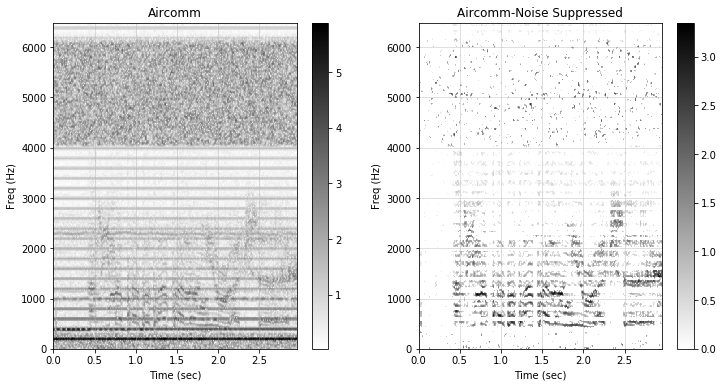

In [11]:
# ssub_aircomm = (np.abs(stft_aircomm).T - np.abs(10**(n_aircomm_stft_db_clipped/20.))).T
ssub_aircomm1 = (np.abs(stft_aircomm).T - 1*np.abs(n_aircomm_stft)).T
ssub_aircomm1[ssub_aircomm1 < 0] = 0
s_ssub_aircomm1 = stft(ssub_aircomm1*np.exp(1j*np.angle(stft_aircomm)), fs_aircomm, dft_size, hop_size, zero_pad, window)
print('Original')
IPython.display.display(IPython.display.Audio(s_aircomm, rate=fs_aircomm))
print('Suppressed too little')
IPython.display.display(IPython.display.Audio(s_ssub_aircomm1, rate=fs_aircomm))

ssub_aircomm = (np.abs(stft_aircomm).T - 2*np.abs(n_aircomm_stft)).T
ssub_aircomm[ssub_aircomm < 0] = 0
s_ssub_aircomm = stft(ssub_aircomm*np.exp(1j*np.angle(stft_aircomm)), fs_aircomm, dft_size, hop_size, zero_pad, window)
print('Suppressed about right')
IPython.display.display(IPython.display.Audio(s_ssub_aircomm, rate=fs_aircomm))

plt.rcParams["figure.figsize"] = (12, 6)
plt.subplot(121)
plt.pcolormesh(t_aircomm, f_aircomm, (np.abs(stft_aircomm)**0.5), cmap='gist_gray_r')
plt.xlabel('Time (sec)')
plt.ylabel('Freq (Hz)')
plt.title('Aircomm')
plt.grid(alpha=0.5)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(t_aircomm, f_aircomm, (np.abs(ssub_aircomm)**0.5), cmap='gist_gray_r')
plt.xlabel('Time (sec)')
plt.ylabel('Freq (Hz)')
plt.title('Aircomm-Noise Suppressed')
plt.grid(alpha=0.5)
plt.colorbar()

ssub_aircomm3 = (np.abs(stft_aircomm).T - 6*np.abs(n_aircomm_stft)).T
ssub_aircomm3[ssub_aircomm3 < 0] = 0
s_ssub_aircomm3 = stft(ssub_aircomm3*np.exp(1j*np.angle(stft_aircomm)), fs_aircomm, dft_size, hop_size, zero_pad, window)
print('Suppressed too much')
IPython.display.display(IPython.display.Audio(s_ssub_aircomm3, rate=fs_aircomm))

plt.show()

Similar to the previous clip, keeping the coefficient too low results in natural-sounding speech but buried in noise; and increasing the coefficient results in decreased noise with musical artifacts and natural-sounding speech. One interesting thing in this clip is, as I increase the coefficient even further in the last case, the female speech sound stayed natural while male sound had robotic artifacts. Hence, we can say that the noise was concentrated more on the lower frequencies and suppressing it the same amount for both lower and higher frequencies resulted in male speech, which has more lower-frequency content than the female speech, having more artifacts. One workaround for this might be applying different suppression coefficients to different frequency regions (or frequencies).

Original


Suppressed too little


Suppressed about right


Suppressed too much


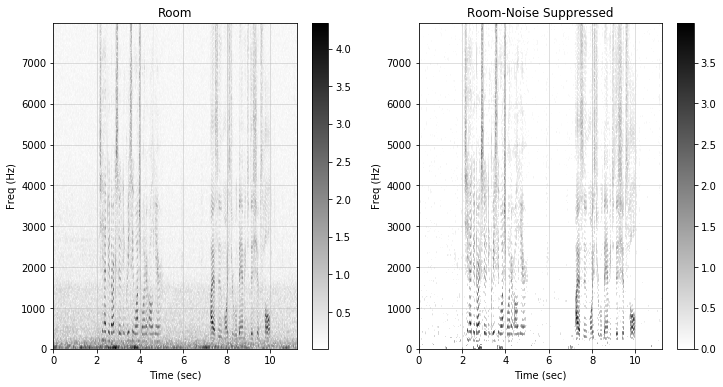

In [17]:
# ssub_room = (np.abs(stft_room).T - np.abs(10**(n_room_stft_db_clipped/20.))).T
ssub_room1 = (np.abs(stft_room).T - 0.5*np.abs(n_room_stft)).T
ssub_room1[ssub_room1 < 0] = 0
s_ssub_room1 = stft(ssub_room1*np.exp(1j*np.angle(stft_room)), fs_room, dft_size, hop_size, zero_pad, window)
print('Original')
IPython.display.display(IPython.display.Audio(s_room, rate=fs_room))
print('Suppressed too little')
IPython.display.display(IPython.display.Audio(s_ssub_room1, rate=fs_room))

ssub_room = (np.abs(stft_room).T - 2*np.abs(n_room_stft)).T
ssub_room[ssub_room < 0] = 0
s_ssub_room = stft(ssub_room*np.exp(1j*np.angle(stft_room)), fs_room, dft_size, hop_size, zero_pad, window)
print('Suppressed about right')
IPython.display.display(IPython.display.Audio(s_ssub_room, rate=fs_room))

plt.subplot(121)
plt.pcolormesh(t_room, f_room, (np.abs(stft_room)**0.4), cmap='gist_gray_r')
plt.xlabel('Time (sec)')
plt.ylabel('Freq (Hz)')
plt.title('Room')
plt.grid(alpha=0.5)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(t_room, f_room, (np.abs(ssub_room)**0.4), cmap='gist_gray_r')
plt.xlabel('Time (sec)')
plt.ylabel('Freq (Hz)')
plt.title('Room-Noise Suppressed')
plt.grid(alpha=0.5)
plt.colorbar()

ssub_room3 = (np.abs(stft_room).T - 6*np.abs(n_room_stft)).T
ssub_room3[ssub_room3 < 0] = 0
s_ssub_room3 = stft(ssub_room3*np.exp(1j*np.angle(stft_room)), fs_room, dft_size, hop_size, zero_pad, window)
print('Suppressed too much')
IPython.display.display(IPython.display.Audio(s_ssub_room3, rate=fs_room))

plt.show()



Again, similarly, suppressing too little did not eliminate the noise in the signal and suppressing too much made it sound robotic. Different from the previous clips, the stationary assumption for the noise does ot hold here. Hence, although the wind noise is removed from the beginning of the clip, it is audible in the second part (after ~ 5 seconds). One way to simply overcome this would be using different noise spectrums to subtract from the signal, one is estimated from the non-speech region at the beginning, and the other is estimated from the non-speech part in the middle. However, the wind frequency seem to be shifting during the second speech part. Hence, even doing so would result in some residual wind noise in the second clip.  

Original


Suppressed too little


Suppressed about right


Suppressed too much


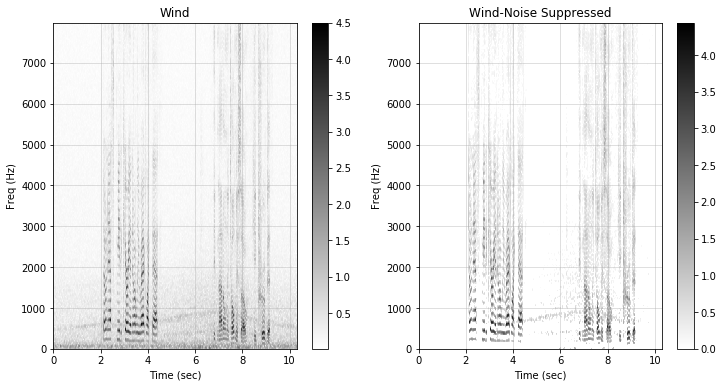

In [15]:
# ssub_wind = (np.abs(stft_wind).T - np.abs(10**(n_wind_stft_db_clipped/20.))).T
ssub_wind1 = (np.abs(stft_wind).T - 1*np.abs(n_wind_stft)).T
ssub_wind1[ssub_wind1 < 0] = 0
s_ssub_wind1 = stft(ssub_wind1*np.exp(1j*np.angle(stft_wind)), fs_wind, dft_size, hop_size, zero_pad, window)
print('Original')
IPython.display.display(IPython.display.Audio(s_wind, rate=fs_wind))
print('Suppressed too little')
IPython.display.display(IPython.display.Audio(s_ssub_wind1, rate=fs_wind))

ssub_wind = (np.abs(stft_wind).T - 4*np.abs(n_wind_stft)).T
ssub_wind[ssub_wind < 0] = 0
s_ssub_wind = stft(ssub_wind*np.exp(1j*np.angle(stft_wind)), fs_wind, dft_size, hop_size, zero_pad, window)
print('Suppressed about right')
IPython.display.display(IPython.display.Audio(s_ssub_wind, rate=fs_wind))

plt.subplot(121)
plt.pcolormesh(t_wind, f_wind, (np.abs(stft_wind)**0.4), cmap='gist_gray_r')
plt.xlabel('Time (sec)')
plt.ylabel('Freq (Hz)')
plt.title('Wind')
plt.grid(alpha=0.5)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(t_wind, f_wind, (np.abs(ssub_wind)**0.4), cmap='gist_gray_r')
plt.xlabel('Time (sec)')
plt.ylabel('Freq (Hz)')
plt.title('Wind-Noise Suppressed')
plt.grid(alpha=0.5)
plt.colorbar()

ssub_wind3 = (np.abs(stft_wind).T - 7.5*np.abs(n_wind_stft)).T
ssub_wind3[ssub_wind3 < 0] = 0
s_ssub_wind3 = stft(ssub_wind3*np.exp(1j*np.angle(stft_wind)), fs_wind, dft_size, hop_size, zero_pad, window)
print('Suppressed too much')
IPython.display.display(IPython.display.Audio(s_ssub_wind3, rate=fs_wind))

plt.show()


Median filtering is used to remove musical noise in the spectrum. Since it replaces "outlier" elements within its kernel with median values, it either smears out or removes the "isolated" components in the spectrum. Hence, using a kernel too big smears the frequency components or removes them altogether and eliminates the subtle frequency changes over time. This results in distorted or imperceivable speech. Using too small kernel, on the other hand, will not remove musical noise as effectively. The optimum size of the kernel will also depend on the noise subtraction coefficient. Smaller subtraction coefficient would tend to leave behind larger size of connected musical noise components, which are harder to remove with median filters with smaller kernels. 

The most obvious effect of median filtering is observed on the first clip, since it had more musical noise after noise subtraction.



Aircomm-Median Filt (5)


Aircomm-Median Filt (11)


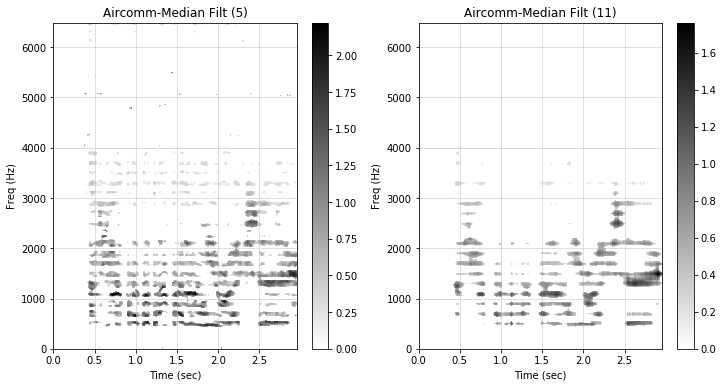

Room-Median Filt (5)


Room-Median Filt (9)


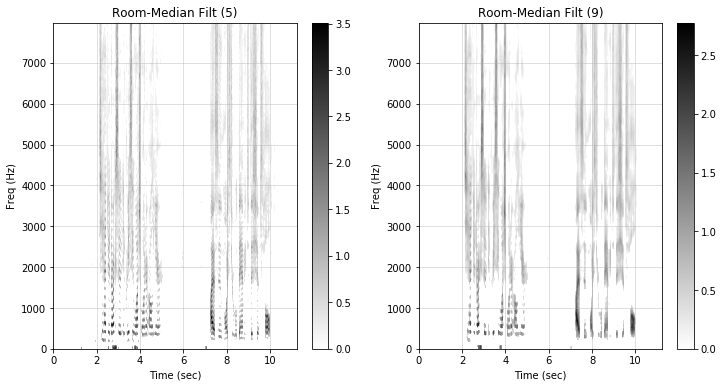

Wind-Median Filt (3)


Wind-Median Filt (13)


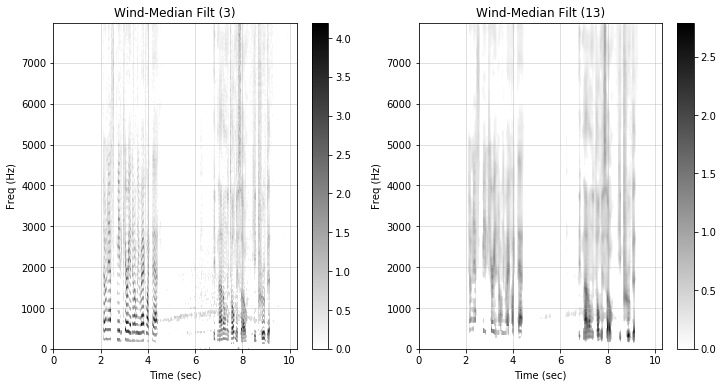

In [18]:
ssub_aircomm_med = sgn.medfilt2d(ssub_aircomm, 5)
s_ssub_aircomm_med = stft(ssub_aircomm_med*np.exp(1j*np.angle(stft_aircomm)), fs_aircomm, dft_size, hop_size, zero_pad, window)

ssub_aircomm_med2 = sgn.medfilt2d(ssub_aircomm, 11)
s_ssub_aircomm_med2 = stft(ssub_aircomm_med2*np.exp(1j*np.angle(stft_aircomm)), fs_aircomm, dft_size, hop_size, zero_pad, window)
print('Aircomm-Median Filt (5)')
IPython.display.display(IPython.display.Audio(s_ssub_aircomm_med, rate=fs_aircomm))
print('Aircomm-Median Filt (11)')
IPython.display.display(IPython.display.Audio(s_ssub_aircomm_med2, rate=fs_aircomm))
plt.subplot(121)
plt.pcolormesh(t_aircomm, f_aircomm, (np.abs(ssub_aircomm_med)**0.4), cmap='gray_r')
plt.xlabel('Time (sec)')
plt.ylabel('Freq (Hz)')
plt.title('Aircomm-Median Filt (5)')
plt.grid(alpha=0.5)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(t_aircomm, f_aircomm, (np.abs(ssub_aircomm_med2)**0.4), cmap='gray_r')
plt.xlabel('Time (sec)')
plt.ylabel('Freq (Hz)')
plt.title('Aircomm-Median Filt (11)')
plt.grid(alpha=0.5)
plt.colorbar()
plt.show()



ssub_room_med = sgn.medfilt2d(ssub_room, 5)
s_ssub_room_med = stft(ssub_room_med*np.exp(1j*np.angle(stft_room)), fs_room, dft_size, hop_size, zero_pad, window)
ssub_room_med2 = sgn.medfilt2d(ssub_room, 9)
s_ssub_room_med2 = stft(ssub_room_med2*np.exp(1j*np.angle(stft_room)), fs_room, dft_size, hop_size, zero_pad, window)
print('Room-Median Filt (5)')
IPython.display.display(IPython.display.Audio(s_ssub_room_med, rate=fs_room))
print('Room-Median Filt (9)')
IPython.display.display(IPython.display.Audio(s_ssub_room_med2, rate=fs_room))
plt.subplot(121)
plt.pcolormesh(t_room, f_room, (np.abs(ssub_room_med)**0.4), cmap='gray_r')
plt.xlabel('Time (sec)')
plt.ylabel('Freq (Hz)')
plt.title('Room-Median Filt (5)')
plt.grid(alpha=0.5)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(t_room, f_room, (np.abs(ssub_room_med2)**0.4), cmap='gray_r')
plt.xlabel('Time (sec)')
plt.ylabel('Freq (Hz)')
plt.title('Room-Median Filt (9)')
plt.grid(alpha=0.5)
plt.colorbar()
plt.show()



ssub_wind_med = sgn.medfilt2d(ssub_wind, 3)
s_ssub_wind_med = stft(ssub_wind_med*np.exp(1j*np.angle(stft_wind)), fs_wind, dft_size, hop_size, zero_pad, window)
ssub_wind_med2 = sgn.medfilt2d(ssub_wind, 13)
s_ssub_wind_med2 = stft(ssub_wind_med2*np.exp(1j*np.angle(stft_wind)), fs_wind, dft_size, hop_size, zero_pad, window)
print('Wind-Median Filt (3)')
IPython.display.display(IPython.display.Audio(s_ssub_wind_med, rate=fs_wind))
print('Wind-Median Filt (13)')
IPython.display.display(IPython.display.Audio(s_ssub_wind_med2, rate=fs_wind))
plt.subplot(121)
plt.pcolormesh(t_wind, f_wind, (np.abs(ssub_wind_med)**0.4), cmap='gray_r')
plt.xlabel('Time (sec)')
plt.ylabel('Freq (Hz)')
plt.title('Wind-Median Filt (3)')
plt.grid(alpha=0.5)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(t_wind, f_wind, (np.abs(ssub_wind_med2)**0.4), cmap='gray_r')
plt.xlabel('Time (sec)')
plt.ylabel('Freq (Hz)')
plt.title('Wind-Median Filt (13)')
plt.grid(alpha=0.5)
plt.colorbar()
plt.show()


Overall, after noise subtraction and median filtering, the first clip is enhanced significantly compared to the original clip. Stationarity of the noise over time made it easier to suppress the noise. Since the original speech signal was unnatural to begin with, there was more room to subtract the noise without making the end result sounding horrible. 

The last clip was the hardest to work with since the frequency of the wind noise was changing over time. It was not enough to use a single noise spectrum to eliminate the noise from the entire clip. An online noise estimation would provide a better denoising for this clip.

For the second one, it was relatively easy to remove the noise since it was constant over time. However, the end result was more sensitive to the subtraction coefficient due to the overlaps in the noise with the different frequency spectrums of the speakers.

## Part 2: Voice Activity Detector 

Since the last clip had the nonstationary noise, the effect of an online noise estimation will be most noticable on that one. Hence, I used the third clip for this part.

First, I determined the noise regions by looking at the energy content of the frames. I set a threshold high enough so that the speech contents will remain intact while keeping noise below the threshold.

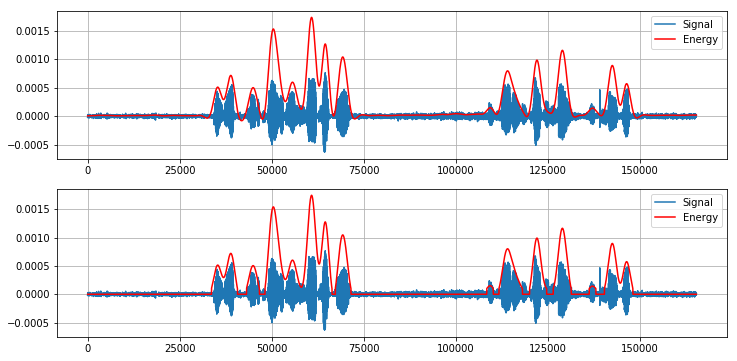

In [19]:
b, a = sgn.iirfilter(3, 4/(fs_wind/2), btype='lowpass')
s_wind_filt = sgn.filtfilt(b, a, s_wind**2)

plt.subplot(211)
plt.plot(s_wind/sum(s_wind**2))
plt.plot(s_wind_filt/sum(s_wind_filt**2), 'r')
plt.grid()
plt.legend(['Signal', 'Energy'])
plt.subplot(212)
s_wind_filt_th = s_wind_filt
th = 0.0001*sum(s_wind_filt**2)
s_wind_filt_th[s_wind_filt < th] = 0
plt.plot(s_wind/sum(s_wind**2))
plt.plot(s_wind_filt_th/sum(s_wind_filt**2), 'r')
plt.grid()
plt.legend(['Signal', 'Energy'])
plt.show()

After finding the non-speech locations, I ran a for loop similar to STFT, but for each frame, if the frame is noise-only, I updated the noise spectrum estimate by averaging over the past <=50 available noise frames. If the frame contained speech, I subtracted the last estimate of noise from the frame. The resulting signal had much less wind noise compared to the previous attempt of removing the noise with fixed spectrum.

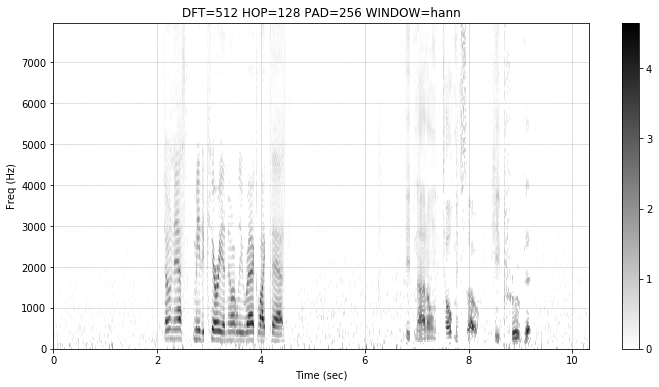

In [61]:
noise_idx = np.zeros(len(s_wind))
noise_idx[s_wind_filt < th] = 1

dft_size = 512
hop_size = int(dft_size/4)
zero_pad = int(dft_size/2)
s_wind_padded = np.zeros(len(s_wind) + dft_size - zero_pad + hop_size - len(s_wind)%hop_size)
s_wind_padded[:len(s_wind)] = s_wind
L = len(s_wind_padded) -  dft_size
stft_output = np.zeros([int((dft_size)/2) + 1, int(L/hop_size)], dtype=complex)
n_noise_frames = 1.
cnt = 0
for i in range(0, int(L/hop_size)):
    frame_idx = np.arange((i*hop_size),(i*hop_size + dft_size - zero_pad))
    seg = s_wind_padded[frame_idx]
    # Apply Hann window
    seg = np.multiply(seg, np.hanning(dft_size - zero_pad))
    # FFT
    s_fft = np.fft.rfft(seg, dft_size)
    s_stft_abs = np.abs(s_fft)
    s_angle = np.angle(s_fft)
    if noise_idx[frame_idx].all():
        # if noise frame, update noise estimate with the last =<20 available noise frames
        if n_noise_frames == 1 or n_noise_frames > 50:
            noise_est_new = s_stft_abs
            n_noise_frames = 1
        else:
            noise_est_new = s_stft_abs + noise_est*(n_noise_frames-1)
        noise_est = noise_est_new/n_noise_frames
        n_noise_frames += 1
        cnt += 1
    else:
        n_noise_frames = 1
    # Perform noise subtraction with the noise estimate
    s_stft_abs = (s_stft_abs - 1.5*noise_est)
    s_stft_abs[s_stft_abs < 0] = 0
    
    stft_output[:,i] = s_stft_abs*np.exp(1j*s_angle)
    
    
X = np.arange(0, (int(L/hop_size)*hop_size)/fs_wind, hop_size/fs_wind)
Y = np.arange(0, fs_wind/2, fs_wind/(2*(int((dft_size)/2) + 1)))
# Make zero elements equal to the smallest value to avoid log(0) for plotting
# min_nonzero = np.min(stft_output[np.nonzero(stft_output)])
# stft_plot = stft_output
# stft_plot[stft_output == 0] = min_nonzero

plt.pcolormesh(X, Y, (np.abs(stft_output)**0.5), cmap='gray_r')
plt.xlabel('Time (sec)')
plt.ylabel('Freq (Hz)')
plt.title('DFT=%d HOP=%d PAD=%d WINDOW=%s' %(dft_size, hop_size, zero_pad, 'hann'))
plt.grid(alpha=0.5)
plt.colorbar()
plt.show()

s_wind_vad = stft(stft_output, fs_wind, dft_size, hop_size, zero_pad, window='hann')
IPython.display.display(IPython.display.Audio(s_wind_vad, rate=fs_wind))